# Import Required Packages

In [67]:
import pandas as pd
import numpy as np

import newsapi
from newsapi import NewsApiClient
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer


# 1. NewsAPI calls

In [6]:
newsapi = NewsApiClient(api_key='a0ab388c38854712aa5d30195138c034')

In [7]:
queries = ['Donald Trump Alaska ','Kamala Harris Alaska', ' Alaska economic policy', 'Alaska education policy', 'Alaska income inequality',
            "Alaska House elections OR Alaska Presidential elections",
            "economic policy OR inflation OR unemployment",
            "education policy OR student debt OR school funding",
            "income OR minimum wage OR tax cuts"]
articles = []

for query in queries:
    response = newsapi.get_everything(
        q=query,
        from_param='2024-11-01',
        to='2024-11-25',
        language='en',
        sort_by='relevancy',
        page=1
    )
    articles.extend(response['articles'])


# Combine all articles into a DataFrame
import pandas as pd
all_articles = pd.DataFrame(articles)


In [9]:
all_articles.to_csv("MediaSentimentData.csv")

# 2. Preprocessed Article Content

In [34]:
all_articles = pd.read_csv("MediaSentimentData_Processed.csv")

all_articles["article_content"] = all_articles["article_content"].astype(str)

# 2. Feature Engineering

## For each factor:

    Extract sentiment scores.
    Use keyword frequency for relevant terms.
    Categorize articles by their topics using topic modeling (e.g., LDA).


## Example Features
    
    Sentiment scores per topic (economy, education, income).
    Frequency of mentions of candidates.
    Economic sentiment polarity.
    Demographic trends (if additional data is available).


In [52]:
# Calculate sentiment scores
all_articles['sentiment'] = all_articles['article_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Keyword frequency for economic terms
economic_terms = ["inflation", "unemployment", "tax cuts", "wage"]
vectorizer = CountVectorizer(vocabulary=economic_terms)
economic_freq = vectorizer.fit_transform(all_articles['article_content'].fillna("")).toarray()
all_articles['economic_score'] = economic_freq.sum(axis=1)

# Add topic labels (economy, education, income)
def label_topic(article):
    if any(term in article for term in economic_terms):
        return "economy"
    elif "education" in article or "student debt" in article:
        return "education"
    elif "income" in article or "wage" in article:
        return "income"
    elif "politics" in article or "Republican" in article or "Democratic" in article:
        return "politics"
    elif "Donald Trump" in article or "Kamala Harris" in article:
        return "candidate"
    else:
        return "Other"

all_articles['topic'] = all_articles['article_content'].apply(label_topic)


In [53]:
all_articles["topic"].value_counts()

topic
economy      154
Other        143
politics     109
education     64
candidate     25
income        10
Name: count, dtype: int64

In [56]:
all_articles[["article_content", "sentiment", "economic_score", "topic"]]

,article_content,sentiment,economic_score,topic
0,NationalTrump picks North Dakota Gov. Doug Bur...,0.091966,0,politics
1,"ByPhilip ElliottNovember 18, 2024 4:28 PM ESTT...",0.093957,0,politics
2,Here’s all you need to know about election nig...,0.122675,0,education
3,EconomyWorkers in 4 states are up for a raise....,0.079821,32,economy
4,"ByNik PopliNovember 18, 2024 2:55 PM ESTPresid...",0.065997,0,politics
...,...,...,...,...
500,"Samsung’s Best S95D OLED TV Is Now $1,100 Off ...",0.265264,0,Other
501,nan,0.000000,0,Other
502,All Eyes on RFK Jr. After Probe Begins Into Do...,0.144867,0,Other
503,Zelensky says Ukraine will lose war if US cuts...,0.059657,0,politics


# WordCloud

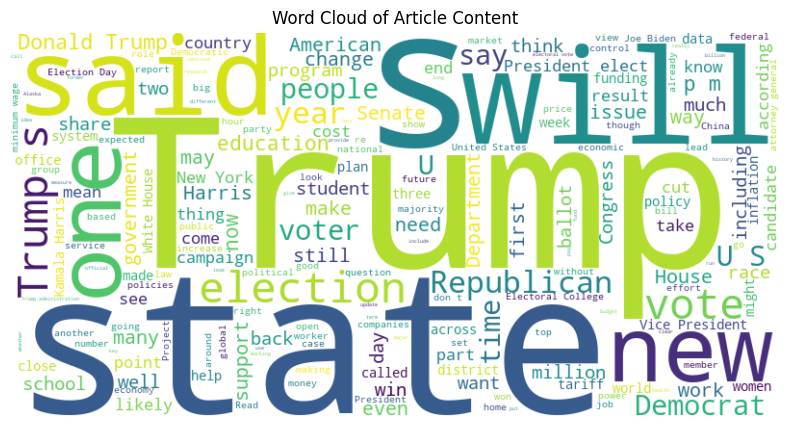

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all article content
text = ' '.join(all_articles['article_content'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Article Content')
plt.show()


# Sentiment distribution

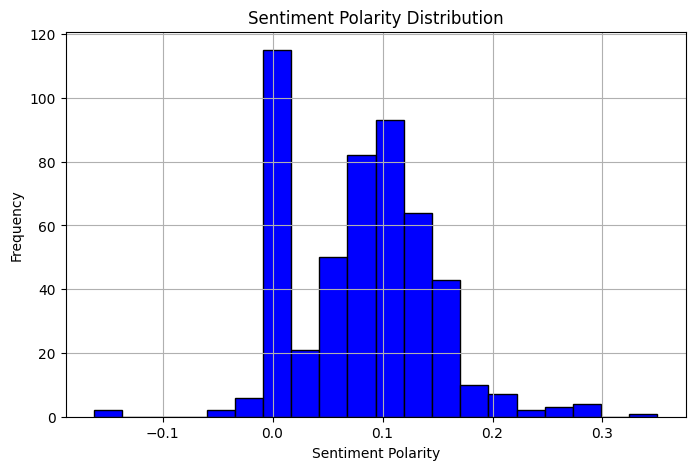

In [60]:
# Sentiment distribution
all_articles['sentiment'].hist(bins=20, color='blue', edgecolor='black', figsize=(8, 5))
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


# Average Sentiment for each Party

Scorecard:
        party  sentiment
0  Democratic   0.103687
1     Neutral   0.000805
2  Republican   0.097346


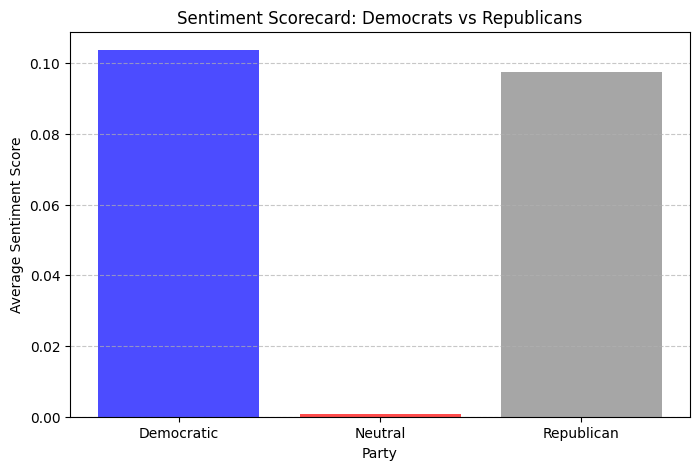

In [70]:
# Define keywords for party identification
democratic_keywords = ['democrat', 'biden', 'democratic party', 'liberal', 'blue']
republican_keywords = ['republican', 'trump', 'gop', 'conservative', 'red']

# Function to classify articles
def classify_party(text):
    text = str(text).lower()
    if any(keyword in text for keyword in democratic_keywords):
        return 'Democratic'
    elif any(keyword in text for keyword in republican_keywords):
        return 'Republican'
    else:
        return 'Neutral'

# Add a new column for party classification
all_articles['party'] = all_articles['article_content'].apply(classify_party)

# Calculate average sentiment for each party
scorecard = all_articles.groupby('party')['sentiment'].mean().reset_index()

# Display the scorecard
print("Scorecard:")
print(scorecard)

# Plot the scorecard
plt.figure(figsize=(8, 5))
plt.bar(scorecard['party'], scorecard['sentiment'], color=['blue', 'red', 'gray'], alpha=0.7)
plt.title('Sentiment Scorecard: Democrats vs Republicans')
plt.xlabel('Party')
plt.ylabel('Average Sentiment Score')
#plt.ylim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [66]:
all_articles["party"].value_counts()

party
Democratic    254
Republican    147
Neutral       104
Name: count, dtype: int64

# Average Sentiment for Each Topic

Scorecard by Topic:
       topic  sentiment
0      Other   0.026943
1  candidate   0.090465
2    economy   0.096704
3  education   0.111455
4     income   0.095862
5   politics   0.106710


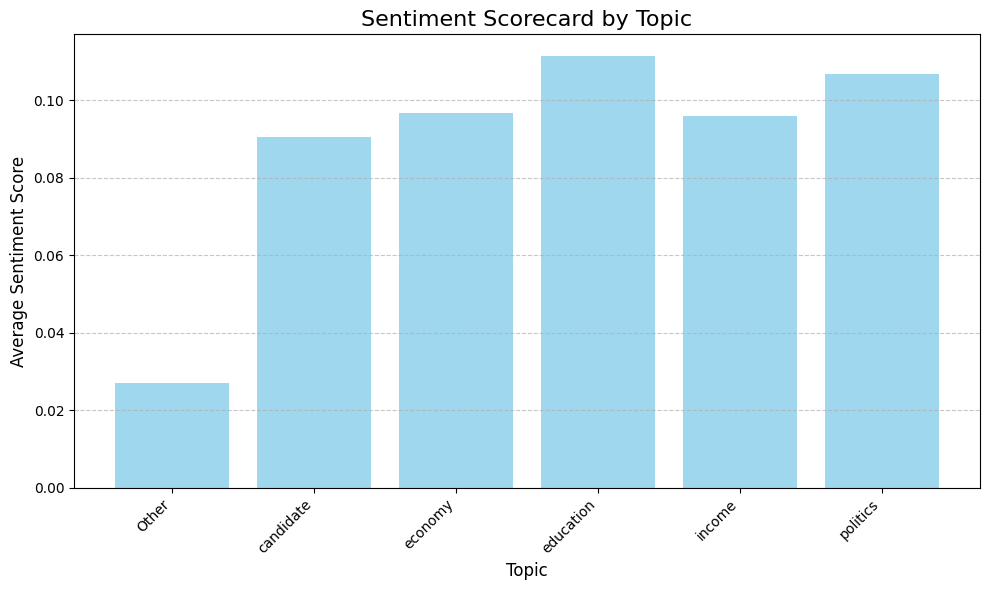

In [69]:
# Calculate average sentiment for each topic
scorecard_topic = all_articles.groupby('topic')['sentiment'].mean().reset_index()

# Display the scorecard
print("Scorecard by Topic:")
print(scorecard_topic)

# Plot the scorecard
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(scorecard_topic['topic'], scorecard_topic['sentiment'], color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Sentiment Scorecard by Topic', fontsize=16)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
#plt.ylim(-1, 1)  # Ensure y-axis represents sentiment polarity (-1 to 1)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add a grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
